In [1]:
import csv
import os
import pickle
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from PIL import Image

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.applications import vgg16, inception_v3, resnet, xception
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
RANDOM_STATE = 42

In [3]:
def load_dataset(target_size):
    x, y = [], []
    base_path = "./data/images/"

    for dir in os.listdir(base_path):
        for image in os.listdir(os.path.join(base_path, dir)):
            image_path = os.path.join(base_path, dir, image)
            image = Image.open(image_path)
            rgb_image = image.copy().convert("RGB")
            x.append(np.array(rgb_image.resize(target_size), dtype=np.uint8))
            y.append(dir)

    return x, y

In [4]:
target_size = (224, 224)

In [5]:
metadata = pd.read_csv("./data/metadata.csv")
meta_filter = metadata[["Channel", "Category"]]
meta_filter = meta_filter.drop_duplicates()
meta_dict = meta_filter.set_index("Channel")["Category"].to_dict()

In [6]:
x, y = load_dataset(target_size)

class: Abroad in Japan


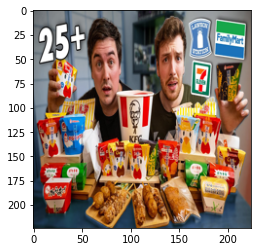

In [7]:
plt.imshow(x[100])
print(f"class: {y[100]}")

In [8]:
print(set(meta_dict.values()))

coarse_dict = {
    'automotive': ['Automobile,Comedy', 'Automobile'],
    'blog': ['Blog,Comedy', 'Blog,Entertainment', 'Blog', 'Blog,Science'],
    'comedy': ['Comedy', 'Comedy,Informative', 'Comedy,Entertainment'],
    'entertainment': ['Entertainment,Blog', 'Entertainment,Comedy', 'Entertainment'],
    'food': ['Food', 'Food,Entertainment'],
    'information': ['Science', 'News', 'Informative'],
    'technology': ['VideoGames', 'Tech,Comedy', 'Tech,News', 'Tech,Informative', 'Tech'],
}

{'Science', 'Blog,Entertainment', 'Comedy,Informative', 'Tech', 'Automobile', 'Food,Entertainment', 'Food', 'Automobile,Comedy', 'VideoGames', 'Blog', 'Informative', 'Tech,Comedy', 'Entertainment', 'Comedy', 'News', 'Tech,News', 'Tech,Informative', 'Blog,Science', 'Entertainment,Comedy', 'Entertainment,Blog', 'Comedy,Entertainment', 'Blog,Comedy'}


In [9]:
y_fine = [meta_dict[item] for item in y]

y_coarse = []
for item in y_fine:
    for key, value in coarse_dict.items():
        if item in value:
            y_coarse.append(key)

In [10]:
print(f"Length Fine: {len(y_fine)} ---  Length Coarse: {len(y_coarse)}")

Length Fine: 2244 ---  Length Coarse: 2244


In [11]:
for i, item in enumerate(y_fine):
    print(f"Fine: {item} --- Coarse: {y_coarse[i]}")

Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Scienc

In [12]:
set_y_coarse = set(y_coarse)
count_dict = {}
for item in set_y_coarse:
    count_dict[item] = y_coarse.count(item)

print(count_dict)

{'blog': 234, 'comedy': 174, 'entertainment': 164, 'technology': 513, 'automotive': 261, 'information': 660, 'food': 238}


In [ ]:
with open("./results/Data/CSV/distribution_v2.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Category", "Count"])
    for category, occurence in count_dict.items():
        writer.writerow([category, occurence])

In [12]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_coarse)
y_one_hot = to_categorical(y_encoded)

In [13]:
sm = SMOTE(random_state=RANDOM_STATE)
x = np.array(x)
n_samples, width, height, n_channels = x.shape

x_flat = x.reshape(n_samples, -1)

x, y_one_hot = sm.fit_resample(x_flat, y_one_hot)
x = x.reshape(-1, width, height, n_channels)

In [14]:
value_distribution = pd.DataFrame([le.classes_[np.argmax(line)] for line in y_one_hot])
print(value_distribution.value_counts())

automotive       660
blog             660
comedy           660
entertainment    660
food             660
information      660
technology       660
dtype: int64


In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y_one_hot, test_size=0.2, random_state=RANDOM_STATE)
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_STATE)
x_train = np.array(x_train)
x_val = np.array(x_val)

print(f"Train Size: {len(y_train)} --- Validation Size: {len(y_val)} --- Test Size: {len(y_test)}")

Train Size: 2956 --- Validation Size: 740 --- Test Size: 924


In [16]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [17]:
train_generator = train_datagen.flow(
    x_train, 
    y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x_val,
    y_val,
    batch_size=32,
    shuffle=False
)

test_generator = test_datagen.flow(
    x_test, 
    y_test,
    batch_size=32,
    shuffle=False
)

# Custom Model Grid Search

In [20]:
def create_custom_cnn(n_filter_1, n_filter_2, kernel_size, pool_size, n_hidden, activation):
    model = Sequential()
    model.add(Conv2D(n_filter_1, kernel_size=kernel_size, activation="relu", input_shape=target_size+(3,)))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(n_filter_2, kernel_size=kernel_size, activation="relu"))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(n_hidden, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(len(le.classes_), activation=activation))
    model.compile(optimizer=Adam(learning_rate=1e-03), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [21]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

model = KerasClassifier(build_fn=create_custom_cnn)
param_grid = {
    'n_filter_1': [32, 64],
    'n_filter_2': [32, 64],
    'kernel_size': [3, 5],
    'pool_size': [2, 3],
    'n_hidden': [64, 128],
    'activation': ['sigmoid', 'softmax']
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  after removing the cwd from sys.path.


Fitting 3 folds for each of 64 candidates, totalling 192 fits
Epoch 1/20
62/62 [==============================] - 5s 19ms/step - loss: 115.8884 - accuracy: 0.2076 - val_loss: 1.8121 - val_accuracy: 0.2986 - lr: 0.0010
Epoch 2/20
62/62 [==============================] - 1s 14ms/step - loss: 1.4751 - accuracy: 0.4964 - val_loss: 1.8476 - val_accuracy: 0.3608 - lr: 0.0010
Epoch 3/20
62/62 [==============================] - 1s 15ms/step - loss: 0.8346 - accuracy: 0.7472 - val_loss: 1.7991 - val_accuracy: 0.4405 - lr: 0.0010
Epoch 4/20
62/62 [==============================] - 1s 15ms/step - loss: 0.4996 - accuracy: 0.8741 - val_loss: 2.2075 - val_accuracy: 0.4338 - lr: 0.0010
Epoch 5/20
62/62 [==============================] - 1s 15ms/step - loss: 0.3295 - accuracy: 0.9234 - val_loss: 2.3968 - val_accuracy: 0.4500 - lr: 0.0010
Epoch 6/20
62/62 [==============================] - 1s 14ms/step - loss: 0.2387 - accuracy: 0.9528 - val_loss: 2.5436 - val_accuracy: 0.4459 - lr: 0.0010
Epoch 7/20
6

# Custom Model

In [40]:
custom_model = Sequential()
custom_model.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=target_size+(3,)))
custom_model.add(MaxPooling2D(pool_size=3))
custom_model.add(Conv2D(64, kernel_size=3, activation="relu"))
custom_model.add(MaxPooling2D(pool_size=3))
custom_model.add(Flatten())
custom_model.add(Dense(128, activation="relu"))
custom_model.add(Dropout(0.3))
custom_model.add(Dense(len(le.classes_), activation="softmax"))

custom_model.compile(optimizer=Adam(learning_rate=1e-03), loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/20
45/45 [==============================] - 38s 820ms/step - loss: 1.8529 - accuracy: 0.2897 - val_loss: 1.7439 - val_accuracy: 0.3287 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - 36s 797ms/step - loss: 1.6660 - accuracy: 0.3489 - val_loss: 1.6500 - val_accuracy: 0.3649 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - 37s 823ms/step - loss: 1.5450 - accuracy: 0.4095 - val_loss: 1.6042 - val_accuracy: 0.4095 - lr: 0.0010
Epoch 4/20
45/45 [==============================] - 37s 810ms/step - loss: 1.4312 - accuracy: 0.4708 - val_loss: 1.5488 - val_accuracy: 0.4708 - lr: 0.0010
Epoch 5/20
45/45 [==============================] - 36s 800ms/step - loss: 1.3883 - accuracy: 0.5014 - val_loss: 1.5142 - val_accuracy: 0.4791 - lr: 0.0010
Epoch 6/20
45/45 [==============================] - 36s 797ms/step - loss: 1.3038 - accuracy: 0.5348 - val_loss: 1.4417 - val_accuracy: 0.4652 - lr: 0.0010
Epoch 7/20
45/45 [==============================] - 38s 837ms/st

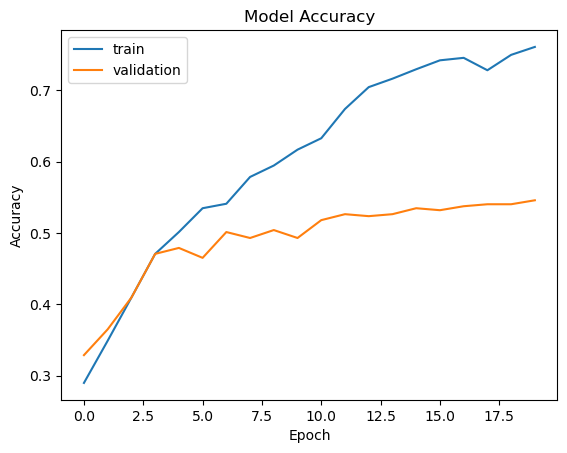

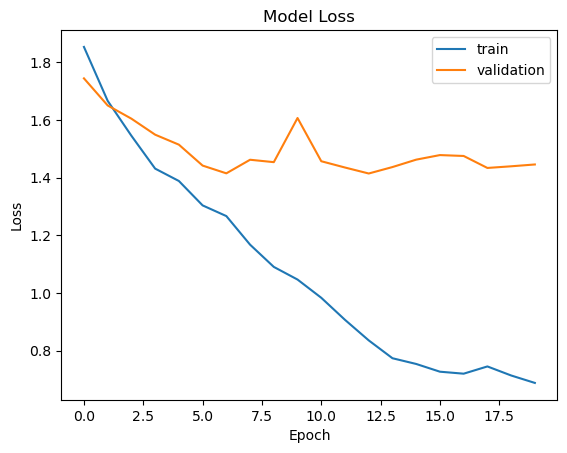

In [41]:
history = custom_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr],
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [22]:
pred = custom_model.predict(x_test)
predictions = np.argmax(pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
acc = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f"Accuracy of {round(acc*100, 2)}%")
cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
cm_display.plot(cmap="Reds", xticks_rotation=90)

NameError: name 'custom_model' is not defined

# Transfer Learning Grid Search

In [25]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

## VGG16

In [23]:
def create_vgg16_model(optimizer, init, n_hidden_1, n_hidden_2, activation):
    base_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=target_size+(3,))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(n_hidden_1, activation="relu", kernel_initializer=init))
    model.add(Dense(n_hidden_2, activation="relu", kernel_initializer=init))
    model.add(Dense(len(le.classes_), activation=activation, kernel_initializer=init))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [26]:
model = KerasClassifier(build_fn=create_vgg16_model)

param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'init': ['glorot_uniform', 'normal'],
    'n_hidden_1': [64, 128],
    'n_hidden_2': [64, 128],
    'activation': ['sigmoid', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/20
62/62 [==============================] - 14s 75ms/step - loss: 2.9764 - accuracy: 0.3822 - val_loss: 0.5117 - val_accuracy: 0.3486 - lr: 0.0010
Epoch 2/20
62/62 [==============================] - 3s 46ms/step - loss: 0.4497 - accuracy: 0.5548 - val_loss: 0.3329 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 3/20
62/62 [==============================] - 3s 45ms/step - loss: 0.2855 - accuracy: 0.6929 - val_loss: 0.5779 - val_accuracy: 0.5149 - lr: 0.0010
Epoch 4/20
62/62 [==============================] - 3s 44ms/step - loss: 0.1936 - accuracy: 0.7904 - val_loss: 0.3452 - val_accuracy: 0.6770 - lr: 0.0010
Epoch 5/20
62/62 [==============================] - 3s 45ms/step - loss: 0.1562 - accuracy: 0.8452 - val_loss: 0.3059 - val_accuracy: 0.6757 - lr: 0.0010
Epoch 6/20
62/62 [==============================] - 3s 44ms/step - loss: 0.1292 - accuracy: 0.8751 - val_loss: 0.3904 - val_accuracy: 0.6649 - lr: 0.0010
Epoch 7/20
62/

## InceptionV3

In [27]:
def create_inceptionv3_model(optimizer, init, n_hidden_1, n_hidden_2, activation):
    base_model = inception_v3.InceptionV3(weights="imagenet", include_top=False, input_shape=target_size+(3,))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(n_hidden_1, activation="relu", kernel_initializer=init))
    model.add(Dense(n_hidden_2, activation="relu", kernel_initializer=init))
    model.add(Dense(len(le.classes_), activation=activation, kernel_initializer=init))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [28]:
model = KerasClassifier(build_fn=create_inceptionv3_model)

param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'init': ['glorot_uniform', 'normal'],
    'n_hidden_1': [64, 128],
    'n_hidden_2': [64, 128],
    'activation': ['sigmoid', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Epoch 1/20
62/62 [==============================] - 7s 69ms/step - loss: 13.4405 - accuracy: 0.1624 - val_loss: 4.3928 - val_accuracy: 0.1568 - lr: 0.0010
Epoch 2/20
62/62 [==============================] - 3s 42ms/step - loss: 1.2021 - accuracy: 0.1675 - val_loss: 0.6559 - val_accuracy: 0.1459 - lr: 0.0010
Epoch 3/20
62/62 [==============================] - 3s 42ms/step - loss: 0.7281 - accuracy: 0.1487 - val_loss: 0.6029 - val_accuracy: 0.1581 - lr: 0.0010
Epoch 4/20
62/62 [==============================] - 3s 42ms/step - loss: 0.5770 - accuracy: 0.1604 - val_loss: 0.5366 - val_accuracy: 0.1581 - lr: 0.0010
Epoch 5/20
62/62 [==============================] - 3s 42ms/step - loss: 0.5143 - accuracy: 0.1563 - val_loss: 0.4739 - val_accuracy: 0.1514 - lr: 0.0010
Epoch 6/20
62/62 [==============================] - 3s 42ms/step - loss: 0.4479 - accuracy: 0.1477 - val_loss: 0.4268 - val_accuracy: 0.1500 - lr: 0.0010
Epoch 7/20
62/62 [==============================] - 3s 42ms/step - loss: 0.

## ResNet50

In [29]:
def create_resnet50_model(optimizer, init, n_hidden_1, n_hidden_2, activation):
    base_model = resnet.ResNet50(weights="imagenet", include_top=False, input_shape=target_size+(3,))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(n_hidden_1, activation="relu", kernel_initializer=init))
    model.add(Dense(n_hidden_2, activation="relu", kernel_initializer=init))
    model.add(Dense(len(le.classes_), activation=activation, kernel_initializer=init))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [30]:
model = KerasClassifier(build_fn=create_resnet50_model)

param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'init': ['glorot_uniform', 'normal'],
    'n_hidden_1': [64, 128],
    'n_hidden_2': [64, 128],
    'activation': ['sigmoid', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Epoch 1/20
62/62 [==============================] - 7s 64ms/step - loss: 1.7459 - accuracy: 0.3259 - val_loss: 0.6015 - val_accuracy: 0.3919 - lr: 0.0010
Epoch 2/20
62/62 [==============================] - 3s 48ms/step - loss: 0.4537 - accuracy: 0.5807 - val_loss: 0.5809 - val_accuracy: 0.4662 - lr: 0.0010
Epoch 3/20
62/62 [==============================] - 3s 46ms/step - loss: 0.2465 - accuracy: 0.7477 - val_loss: 0.6245 - val_accuracy: 0.5081 - lr: 0.0010
Epoch 4/20
62/62 [==============================] - 3s 47ms/step - loss: 0.1386 - accuracy: 0.8802 - val_loss: 0.2970 - val_accuracy: 0.7243 - lr: 0.0010
Epoch 5/20
62/62 [==============================] - 3s 46ms/step - loss: 0.0920 - accuracy: 0.9213 - val_loss: 0.4259 - val_accuracy: 0.6824 - lr: 0.0010
Epoch 6/20
62/62 [==============================] - 3s 46ms/step - loss: 0.0403 - accuracy: 0.9695 - val_loss: 0.3407 - val_accuracy: 0.7284 - lr: 0.0010
Epoch 7/20
62/62 [==============================] - 3s 46ms/step - loss: 0.0

## Xception

In [31]:
def create_xception_model(optimizer, init, n_hidden_1, n_hidden_2, activation):
    base_model = xception.Xception(weights="imagenet", include_top=False, input_shape=target_size+(3,))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(n_hidden_1, activation="relu", kernel_initializer=init))
    model.add(Dense(n_hidden_2, activation="relu", kernel_initializer=init))
    model.add(Dense(len(le.classes_), activation=activation, kernel_initializer=init))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [32]:
model = KerasClassifier(build_fn=create_xception_model)

param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'init': ['glorot_uniform', 'normal'],
    'n_hidden_1': [64, 128],
    'n_hidden_2': [64, 128],
    'activation': ['sigmoid', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Epoch 1/20
62/62 [==============================] - 7s 80ms/step - loss: 5.5052 - accuracy: 0.1716 - val_loss: 0.5558 - val_accuracy: 0.1459 - lr: 0.0010
Epoch 2/20
62/62 [==============================] - 4s 60ms/step - loss: 0.5941 - accuracy: 0.1523 - val_loss: 0.4440 - val_accuracy: 0.1405 - lr: 0.0010
Epoch 3/20
62/62 [==============================] - 4s 61ms/step - loss: 0.4856 - accuracy: 0.1416 - val_loss: 0.5782 - val_accuracy: 0.1405 - lr: 0.0010
Epoch 4/20
62/62 [==============================] - 4s 60ms/step - loss: 0.4747 - accuracy: 0.1477 - val_loss: 0.4607 - val_accuracy: 0.1351 - lr: 0.0010
Epoch 5/20
62/62 [==============================] - 4s 62ms/step - loss: 0.4579 - accuracy: 0.1629 - val_loss: 0.4575 - val_accuracy: 0.1446 - lr: 0.0010
Epoch 6/20
62/62 [==============================] - 4s 63ms/step - loss: 0.4623 - accuracy: 0.1467 - val_loss: 0.4341 - val_accuracy: 0.1514 - lr: 0.0010
Epoch 7/20
62/62 [==============================] - 4s 60ms/step - loss: 0.4

# Transfer Learning application

VGG16: {'activation': 'sigmoid', 'init': 'glorot_uniform', 'n_hidden_1': 128, 'n_hidden_2': 64, 'optimizer': 'adam'} 0.75  
InceptionV3: {'activation': 'softmax', 'init': 'glorot_uniform', 'n_hidden_1': 64, 'n_hidden_2': 64, 'optimizer': 'adam'} 0.43  
ResNet50: {'activation': 'sigmoid', 'init': 'glorot_uniform', 'n_hidden_1': 64, 'n_hidden_2': 64, 'optimizer': 'adam'} 0.76  
Xception: {'activation': 'sigmoid', 'init': 'glorot_uniform', 'n_hidden_1': 128, 'n_hidden_2': 64, 'optimizer': 'adam'} 0.52

In [18]:
model_vgg_16 = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=target_size+(3,))
model_inception_v3 = inception_v3.InceptionV3(weights="imagenet", include_top=False, input_shape=target_size+(3,))
model_resnet_50 = resnet.ResNet50(weights="imagenet", include_top=False, input_shape=target_size+(3,))
model_xception = xception.Xception(weights="imagenet", include_top=False, input_shape=target_size+(3,))

In [19]:
model_dict = {
    'vgg_16': model_vgg_16,
    'inception_v3': model_inception_v3,
    'resnet_50': model_resnet_50,
    'xception': model_xception
}

for key, value in model_dict.items():
    for layer in value.layers:
        layer.trainable = False

In [23]:
dropout = 0.2
learning_rate = 1e-03
epochs = 20

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)


In [21]:
for key, value in model_dict.items():
    model = Sequential()
    model.add(value)
    model.add(Flatten())
    if key == "vgg_16" or key == "xception":
        model.add(Dense(128, activation="relu"))
    else:
        model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    if key == "inception_v3":
        model.add(Dense(len(le.classes_), activation="softmax"))
    else:
        model.add(Dense(len(le.classes_), activation="sigmoid"))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])

    model_dict[key] = model

In [25]:
classification_head = model_vgg_16.output
classification_head = Flatten()(classification_head)
classification_head = Dense(128, activation="relu")(classification_head)
classification_head = BatchNormalization()(classification_head)
classification_head = Dropout(dropout)(classification_head)
classification_head = Dense(64, activation="relu")(classification_head)
classification_head = BatchNormalization()(classification_head)
classification_head = Dropout(dropout)(classification_head)
classification_head = Dense(len(le.classes_), activation="sigmoid")(classification_head)

xai_model = Model(inputs=model_vgg_16.input, outputs=classification_head)

xai_model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])

In [26]:
xai_history = xai_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
93/93 [==============================] - 22s 191ms/step - loss: 1.5463 - accuracy: 0.4614 - val_loss: 2.3551 - val_accuracy: 0.3689 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 16s 177ms/step - loss: 0.9520 - accuracy: 0.6607 - val_loss: 2.0456 - val_accuracy: 0.3946 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 17s 177ms/step - loss: 0.6997 - accuracy: 0.7585 - val_loss: 0.9428 - val_accuracy: 0.7014 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 17s 177ms/step - loss: 0.5717 - accuracy: 0.8109 - val_loss: 0.8924 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 16s 177ms/step - loss: 0.4937 - accuracy: 0.8315 - val_loss: 0.8311 - val_accuracy: 0.7351 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 17s 177ms/step - loss: 0.4347 - accuracy: 0.8586 - val_loss: 2.2493 - val_accuracy: 0.4581 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 17s 177ms/st

In [22]:
history_dict = {}

for key, value in model_dict.items():

    if key == 'inception_v3':
        break

    print(f"[INFO] --- Training of {key}")

    early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

    history = value.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stop, reduce_lr],
    )

    history_dict[key] = history

[INFO] --- Training of vgg_16
Epoch 1/20
93/93 [==============================] - 27s 192ms/step - loss: 1.5444 - accuracy: 0.4672 - val_loss: 1.7058 - val_accuracy: 0.4824 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 16s 176ms/step - loss: 0.9500 - accuracy: 0.6587 - val_loss: 1.0892 - val_accuracy: 0.6189 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 17s 179ms/step - loss: 0.7293 - accuracy: 0.7419 - val_loss: 0.8599 - val_accuracy: 0.6973 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 16s 176ms/step - loss: 0.5914 - accuracy: 0.7879 - val_loss: 1.1716 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 16s 177ms/step - loss: 0.4692 - accuracy: 0.8478 - val_loss: 0.9578 - val_accuracy: 0.7189 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 16s 177ms/step - loss: 0.4155 - accuracy: 0.8552 - val_loss: 0.8953 - val_accuracy: 0.7311 - lr: 0.0010
Epoch 7/20
93/93 [================

History for vgg_16


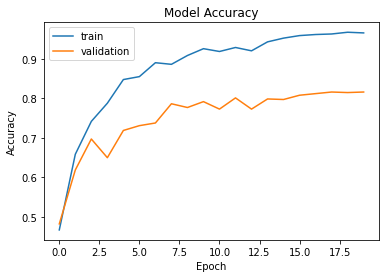

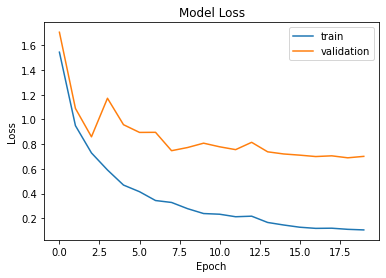

In [23]:
for key, history in history_dict.items():
    print(f"History for {key}")
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # plot training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

Accuracy of 79.22%
Accuracy of 14.94%
Accuracy of 14.18%
Accuracy of 13.53%


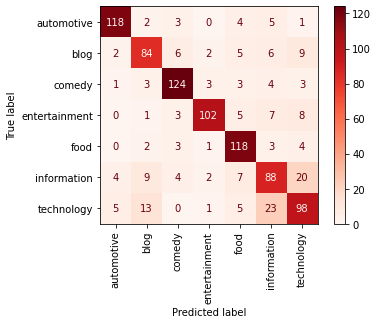

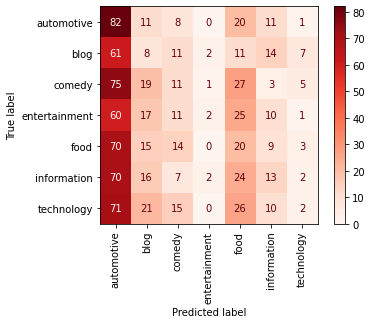

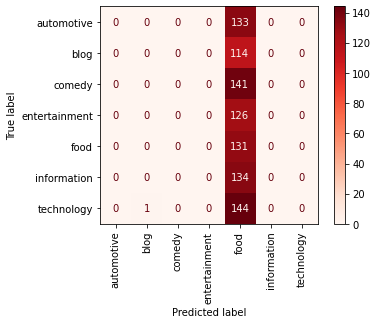

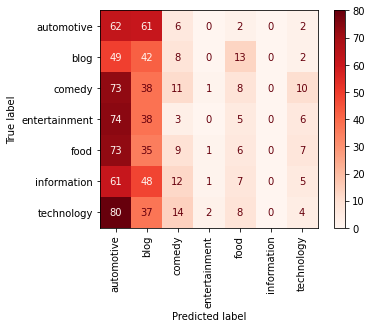

In [24]:
for key, value in model_dict.items():
    pred = value.predict(test_generator)
    predictions = np.argmax(pred, axis=1)
    cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
    acc = accuracy_score(np.argmax(y_test, axis=1), predictions)
    print(f"Accuracy of {round(acc*100,2)}%")
    cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    cm_display.plot(cmap="Reds", xticks_rotation=90)

Accuracy of 79.44%


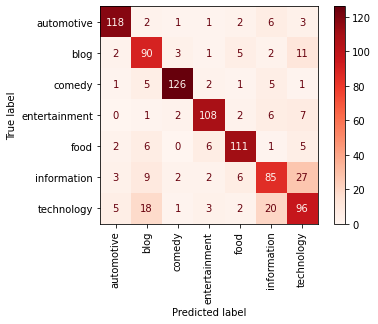

In [27]:
pred = xai_model.predict(test_generator)
predictions = np.argmax(pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
acc = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f"Accuracy of {round(acc*100,2)}%")
cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
cm_display.plot(cmap="Reds", xticks_rotation=90)

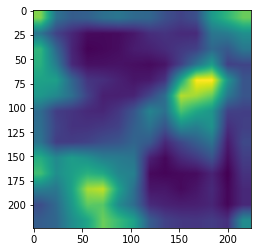

In [41]:
from xai_methods import grad_cam

scaled_heatmap = grad_cam(img=x_test[8][np.newaxis, :], model=xai_model, layer_name="block5_conv3")

plt.imshow(scaled_heatmap)

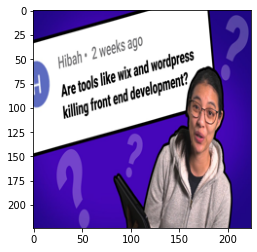

In [39]:
plt.imshow(x_test[8])

In [43]:
import cv2
import tensorflow as tf

from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

def preprocess_img(img_dir):
    img = image.load_img(img_dir, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)


def grad_cam(img_dir, model, layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        img = preprocess_img(img_dir)
        layer_output, predictions = grad_model(img)
        loss = predictions[:, 0]

    gradients = tape.gradient(loss, layer_output)[0]
    casted_layer_output = tf.cast(layer_output > 0, "float32")
    casted_gradients = tf.cast(gradients > 0, "float32")
    guided_gradients = casted_layer_output * casted_gradients * gradients

    # Remove unnecessary dims
    layer_output = layer_output[0]

    weights = tf.reduce_mean(guided_gradients, axis=(0,1))
    grad_cam = tf.reduce_sum(tf.multiply(weights, layer_output), axis=-1)

    width, height = img.shape[2], img.shape[1]
    heatmap = cv2.resize(grad_cam.numpy(), (width, height))
    counter = heatmap - np.min(heatmap)
    denominator = (heatmap.max() - heatmap.min())

    scaled_heatmap = counter / denominator
    
    return scaled_heatmap

In [45]:
plt.imshow(grad_cam("C:/Users/Dominik Hahn/Documents/GitHub/VisualAnalytics/data/images/VICE/xoKwbbnlxi0.jpg", xai_model, "block5_conv3"))

ValueError: No such layer: block5_conv3. Existing layers are [<keras.engine.functional.Functional object at 0x000001CCDF11BBC8>, <keras.layers.core.flatten.Flatten object at 0x000001CE11C48948>, <keras.layers.core.dense.Dense object at 0x000001CE11D6ED88>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001CE11BD30C8>, <keras.layers.core.dropout.Dropout object at 0x000001CE12087E48>, <keras.layers.core.dense.Dense object at 0x000001CE11C359C8>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001CE1208E588>, <keras.layers.core.dropout.Dropout object at 0x000001CE1207B448>, <keras.layers.core.dense.Dense object at 0x000001CE12092B88>].